In [ ]:
#Kevin Madden and Aaron Skow
#ECGR 4106/5106 Final Project
#Due Date: 5/13/2022
#Professor: Dr. Hamed Tabkhi, PH.D.

#import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import skimage
from skimage.transform import resize
import os
import torch
import glob
import random
import torch.nn as nn
import torch.optim as op
import torch.nn.functional as F
import datetime
from torchvision import models

from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms

In [ ]:
#To download from kaggle I had to get a json file by making an account
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Download dataset
!kaggle datasets download grassknoted/asl-alphabet

 99% 1.02G/1.03G [00:20<00:00, 37.5MB/s]
100% 1.03G/1.03G [00:20<00:00, 52.6MB/s]


In [ ]:
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [ ]:
#Test dataset provided by Dan Rasband
!kaggle datasets download danrasband/asl-alphabet-test

  0% 0.00/24.3M [00:00<?, ?B/s]
100% 24.3M/24.3M [00:00<00:00, 334MB/s]


In [ ]:
!unzip asl-alphabet-test.zip

Archive:  asl-alphabet-test.zip
  inflating: A/A0001_test.jpg        
  inflating: A/A0002_test.jpg        
  inflating: A/A0003_test.jpg        
  inflating: A/A0004_test.jpg        
  inflating: A/A0005_test.jpg        
  inflating: A/A0006_test.jpg        
  inflating: A/A0007_test.jpg        
  inflating: A/A0008_test.jpg        
  inflating: A/A0009_test.jpg        
  inflating: A/A0010_test.jpg        
  inflating: A/A0011_test.jpg        
  inflating: A/A0012_test.jpg        
  inflating: A/A0013_test.jpg        
  inflating: A/A0014_test.jpg        
  inflating: A/A0015_test.jpg        
  inflating: A/A0016_test.jpg        
  inflating: A/A0017_test.jpg        
  inflating: A/A0018_test.jpg        
  inflating: A/A0019_test.jpg        
  inflating: A/A0020_test.jpg        
  inflating: A/A0021_test.jpg        
  inflating: A/A0022_test.jpg        
  inflating: A/A0023_test.jpg        
  inflating: A/A0024_test.jpg        
  inflating: A/A0025_test.jpg        
  inflating: A/A00

In [ ]:
#Choose GPU if available
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
#Note that the path "aaron_test" must be created because the test set
#initializes in the google colab space without an overarching folder
data_path = '/content/asl_alphabet_train/asl_alphabet_train'
test_data_path = '/content/aaron_test'

#Borrowed this cell to import dataset from online (need to include reference)

train_transforms = transforms.Compose(
[transforms.Resize([64, 64]),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225])])


test_transforms = transforms.Compose(
[transforms.Resize([64, 64]),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225])])
 
data = datasets.ImageFolder(data_path, transform=train_transforms)
num_samples = len(data)
num_samples

87000

In [ ]:
#creating a dataset class for the test data
test_data = datasets.ImageFolder(test_data_path, transform=test_transforms)
num_test_samples = len(test_data)
num_test_samples

870

In [ ]:
#Overall Settings
test_size = 0.2
batch_size = 128
num_epoch = 10
learning_rate = 0.01
num_classes = 29

In [ ]:
#random seeding of the data
torch.manual_seed(1)
indices = torch.randperm(num_samples)

#Splitting the training and validation data
split = int(num_samples * test_size)
train_dataset = torch.utils.data.Subset(data, indices[split:])
val_dataset = torch.utils.data.Subset(data, indices[:split])

len(train_dataset), len(val_dataset)

(69600, 17400)

In [ ]:
#creating data loaders for all 3 sets and establishing a "classes" to reference for webcam testing
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size, 
                                               shuffle=True)

val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)

classes = train_dataloader.dataset.dataset.classes

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground truth Y


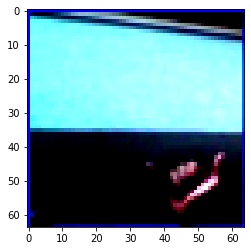

In [ ]:
for img, label in train_dataloader:
    print('Ground truth', classes[label[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    plt.show()
    break

In [ ]:
#Not necessary to run this code. Only used to see what models are available
dir(models)

['AlexNet',
 'ConvNeXt',
 'DenseNet',
 'EfficientNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'MobileNetV3',
 'RegNet',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 'VisionTransformer',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'convnext',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'efficientnet',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'feature_extraction',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3_large',
 '

In [ ]:
#importing the chosen model
from torchvision.models import densenet121
model = models.densenet121(pretrained=True).to(device=device)

In [ ]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#Create training loop
def training_loop(n_epochs, optimizer, model, loss_fn, train_dataloader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_dataloader:
          imgs = imgs.to(device=device)
          labels = labels.to(device=device)
          outputs = model(imgs)
          loss = loss_fn(outputs, labels)
 
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          loss_train += loss.item()

        if epoch == 1 or epoch % 1 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_dataloader)))

In [ ]:
#Making it so that the model resets after training
for param in model.parameters():
    param.requires_grad = False

In [ ]:
#Changing the number of outpout classes to 29 to match our set.
#Comiling model
model.classifier = nn.Linear(1024, num_classes)
optimizer = op.SGD(model.parameters(), momentum=0.9, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
#Sanity checks
model.to(device)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#Choose GPU if available
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
#Call training loop
training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_dataloader = train_dataloader,
)

2022-05-12 00:13:04.003350 Epoch 1, Training loss 0.7604005840771338
2022-05-12 00:14:54.282416 Epoch 2, Training loss 0.3715000893537174
2022-05-12 00:16:47.931646 Epoch 3, Training loss 0.3078128774102558
2022-05-12 00:18:40.949267 Epoch 4, Training loss 0.2749421894824242
2022-05-12 00:20:33.008127 Epoch 5, Training loss 0.2552870178923887
2022-05-12 00:22:24.341203 Epoch 6, Training loss 0.24256731508135357
2022-05-12 00:24:15.240896 Epoch 7, Training loss 0.23082617540186381
2022-05-12 00:26:04.852754 Epoch 8, Training loss 0.2223895641235525
2022-05-12 00:27:54.179173 Epoch 9, Training loss 0.21373599522527964
2022-05-12 00:29:43.056922 Epoch 10, Training loss 0.2092087338815498


In [ ]:
#Create validate loop
def validate(model, train_dataloader, val_dataloader, test_dataloader):
  for name, loader in [("train", train_dataloader), ("val", val_dataloader), ("test", test_dataloader)]:
    correct = 0
    total = 0

    with torch.no_grad():
      for imgs, labels in loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim = 1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_dataloader, val_dataloader, test_dataloader)

Accuracy train: 0.96
Accuracy val: 0.95
Accuracy test: 0.14


In [ ]:
#Importing the larger densenet for testing
from torchvision.models import densenet201
model = models.densenet201(pretrained=True).to(device=device)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

In [ ]:
#Making it so that the model resets after training
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#Changing the number of outpout classes to 29 to match our set.
#Comiling model
model.classifier = nn.Linear(1920, num_classes)
optimizer = op.SGD(model.parameters(), momentum=0.9, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
#Sanity checks
model.to(device)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#Call training loop
training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_dataloader = train_dataloader,
)

2022-05-12 01:05:19.129040 Epoch 1, Training loss 0.6853541966308566
2022-05-12 01:07:15.697061 Epoch 2, Training loss 0.28829388545059104
2022-05-12 01:09:12.843327 Epoch 3, Training loss 0.22597873004098587
2022-05-12 01:11:09.545189 Epoch 4, Training loss 0.19503794084577
2022-05-12 01:13:06.394469 Epoch 5, Training loss 0.17779331035254634
2022-05-12 01:15:03.280877 Epoch 6, Training loss 0.16334265823859503
2022-05-12 01:17:00.176454 Epoch 7, Training loss 0.15155887706479168
2022-05-12 01:18:57.330282 Epoch 8, Training loss 0.1448768748258076
2022-05-12 01:20:54.671629 Epoch 9, Training loss 0.13744710187208564
2022-05-12 01:22:53.119047 Epoch 10, Training loss 0.1336173152222353


In [ ]:
#Validating densent201
validate(model, train_dataloader, val_dataloader)

Accuracy train: 0.97
Accuracy val: 0.95
Accuracy test: 0.16


In [ ]:
#remnants of a failed 60 epoch training with densenet201
model = models.densenet121(pretrained=True).to(device=device)
model.classifier = nn.Linear(1024, num_classes)
optimizer = op.SGD(model.parameters(), momentum=0.9, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
model.to(device)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#Call training loop
training_loop(
    n_epochs = 60,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_dataloader = train_dataloader,
)

2022-05-12 04:38:39.779823 Epoch 1, Training loss 0.12184847221268523
2022-05-12 04:40:52.937000 Epoch 2, Training loss 0.001085920586480343
2022-05-12 04:43:06.155458 Epoch 3, Training loss 0.0002840919682030825
2022-05-12 04:45:19.269777 Epoch 4, Training loss 0.0001716308579021001
2022-05-12 04:47:32.471025 Epoch 5, Training loss 0.00012788741069283895
2022-05-12 04:49:45.902126 Epoch 6, Training loss 0.00010519057369653157
2022-05-12 04:51:58.656308 Epoch 7, Training loss 8.300378570592169e-05
2022-05-12 04:54:11.130942 Epoch 8, Training loss 8.141927740807125e-05
2022-05-12 04:56:23.444801 Epoch 9, Training loss 6.118038320036088e-05
2022-05-12 04:58:35.827179 Epoch 10, Training loss 5.788560285262012e-05
2022-05-12 05:00:48.497231 Epoch 11, Training loss 0.0015893207243493634
2022-05-12 05:03:02.164899 Epoch 12, Training loss 0.00043537546710414226
2022-05-12 05:05:14.622749 Epoch 13, Training loss 0.00015512708867337257
2022-05-12 05:07:27.709180 Epoch 14, Training loss 6.772091

In [1]:
validate(model, train_dataloader, val_dataloader, test_dataloader)

NameError: ignored